In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neurips-open-polymer-prediction-2025/sample_submission.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train.csv
/kaggle/input/neurips-open-polymer-prediction-2025/test.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset2.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset4.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset1.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset3.csv


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7973 entries, 0 to 7972
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       7973 non-null   int64  
 1   SMILES   7973 non-null   object 
 2   Tg       511 non-null    float64
 3   FFV      7030 non-null   float64
 4   Tc       737 non-null    float64
 5   Density  613 non-null    float64
 6   Rg       614 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 436.2+ KB


--- Summary Statistics for Target Variables ---
          Density          Tc          Tg          Rg          FFV
count  613.000000  737.000000  511.000000  614.000000  7030.000000
mean     0.985484    0.256334   96.452314   16.419787     0.367212
std      0.146189    0.089538  111.228279    4.608640     0.029609
min      0.748691    0.046500 -148.029738    9.728355     0.226992
25%      0.890243    0.186000   13.674509   12.540328     0.349549
50%     

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

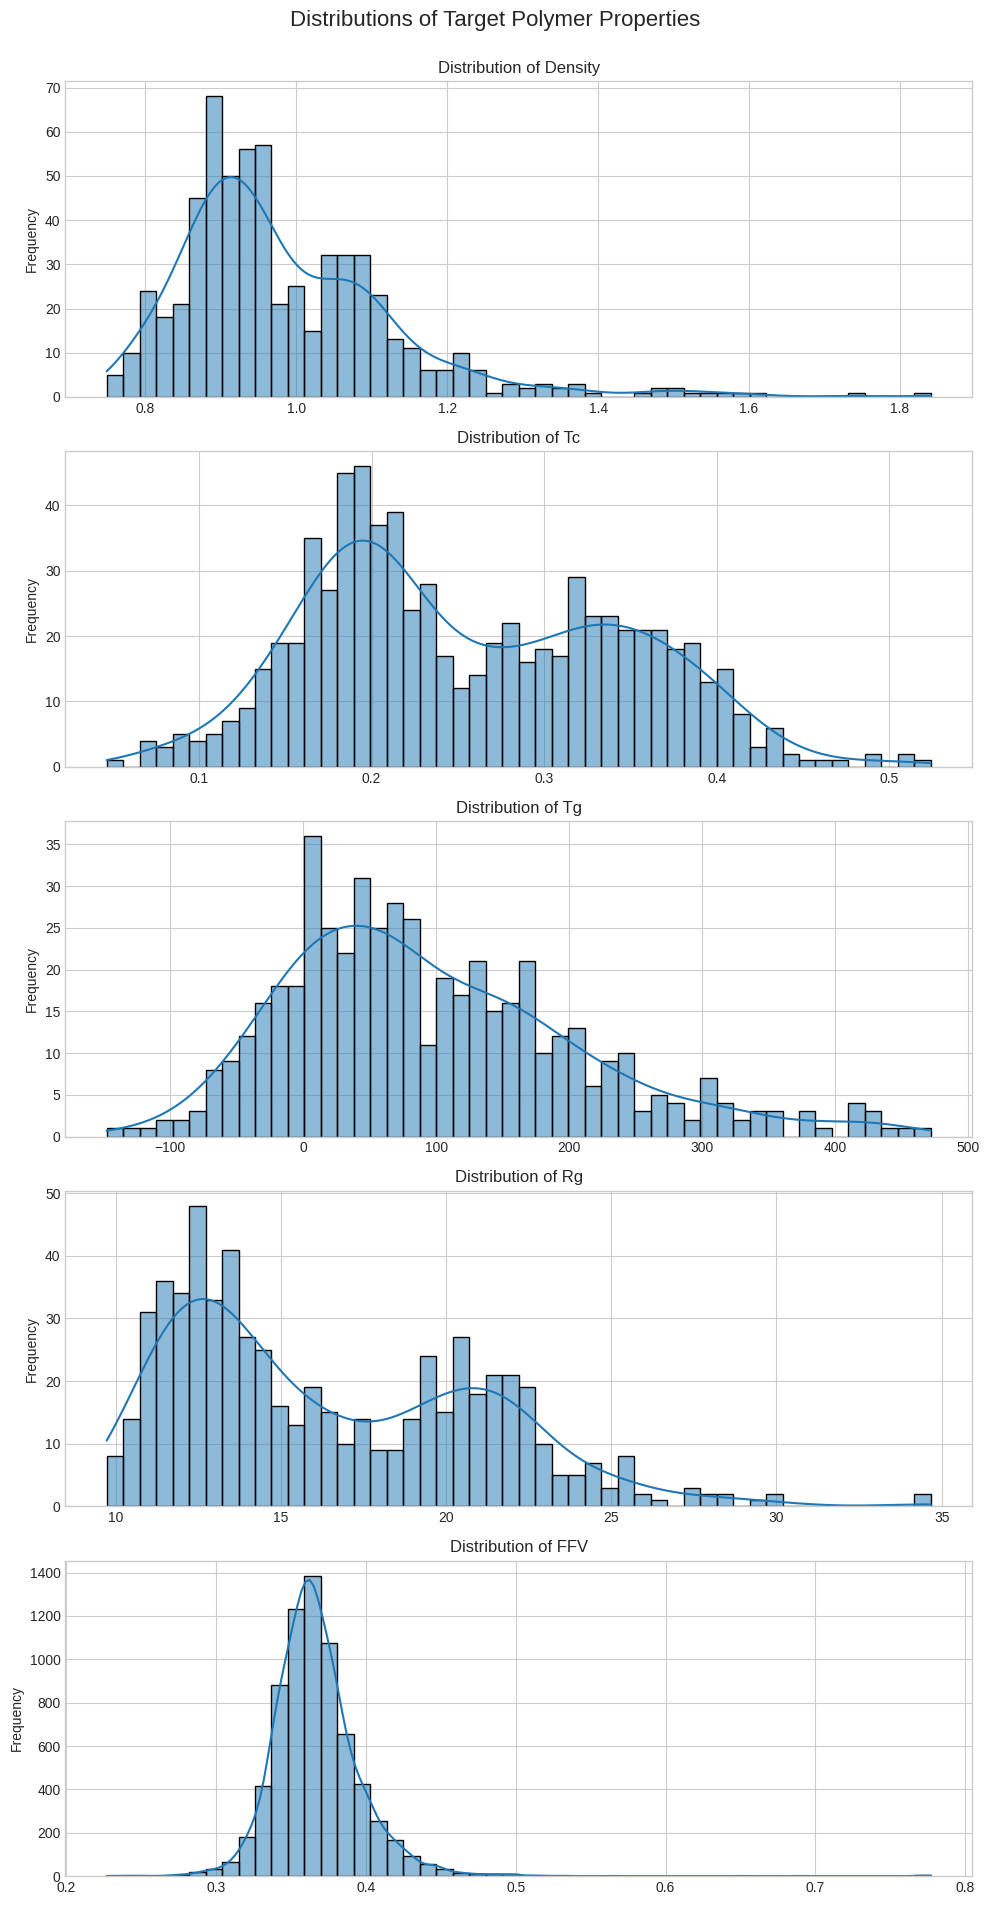

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Let's assume the data is in the default Kaggle input directory
# If you're running this locally, change the path to where you've saved the file.
try:
    train_df = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/train.csv')
except FileNotFoundError:
    # A fallback for local execution if the above path doesn't exist.
    # IMPORTANT: You'll need to download the 'train.csv' file and place it
    # in a folder named 'data' in the same directory as your script.
    print("Kaggle directory not found. Trying local path './data/train.csv'")
    train_df = pd.read_csv('./data/train.csv')


# 1. Basic Information
print("--- Dataset Information ---")
train_df.info()

print("\n" + "="*50 + "\n")

# 2. Summary Statistics for Target Variables
target_columns = ['Density', 'Tc', 'Tg', 'Rg', 'FFV']
print("--- Summary Statistics for Target Variables ---")
print(train_df[target_columns].describe())

print("\n" + "="*50 + "\n")


# 3. Visualize the Distributions of Target Variables
print("--- Visualizing Target Variable Distributions ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=len(target_columns), ncols=1, figsize=(10, 20))
fig.suptitle('Distributions of Target Polymer Properties', fontsize=16)

for i, col in enumerate(target_columns):
    sns.histplot(train_df[col], kde=True, ax=axes[i], bins=50)
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [3]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 30.4 MB/s eta 0:00:0000:0100:01


In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm import tqdm

# --- Load Data (assuming train_df is already loaded) ---
# train_df = pd.read_csv('./data/train.csv') 

# --- Feature Engineering with RDKit ---

# It's good practice to register tqdm with pandas for the progress bar
tqdm.pandas()

def calculate_descriptors(smiles_string):
    """
    Calculates a set of molecular descriptors from a SMILES string.
    Includes error handling for invalid SMILES.
    """
    mol = Chem.MolFromSmiles(smiles_string)
    
    if mol is None:
        # Return NaNs if RDKit cannot parse the SMILES string
        return [None] * 5 
    
    # Calculate the descriptors
    mol_wt = Descriptors.MolWt(mol)
    num_heavy_atoms = Descriptors.HeavyAtomCount(mol)
    num_rotatable_bonds = Descriptors.NumRotatableBonds(mol)
    log_p = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    
    return [mol_wt, num_heavy_atoms, num_rotatable_bonds, log_p, tpsa]

# Column names for our new features
descriptor_names = [
    'MolWt', 
    'HeavyAtomCount', 
    'NumRotatableBonds', 
    'MolLogP', 
    'TPSA'
]

# Apply the function to the SMILES column. 
# The .progress_apply shows the progress bar.
print("Calculating molecular descriptors... (this may take a minute)")
features = train_df['SMILES'].progress_apply(calculate_descriptors)

# Convert the list of lists into a new DataFrame
features_df = pd.DataFrame(features.tolist(), columns=descriptor_names)

# Combine the new features with the original DataFrame
df_featured = pd.concat([train_df, features_df], axis=1)


# --- Display Results ---
print("\n--- Dataframe with new features ---")
print(df_featured.head())

print("\n--- Basic stats for new features ---")
print(df_featured[descriptor_names].describe())

Calculating molecular descriptors... (this may take a minute)


100%|██████████| 7973/7973 [00:07<00:00, 1096.72it/s]


--- Dataframe with new features ---
       id                                             SMILES  Tg       FFV  \
0   87817                         *CC(*)c1ccccc1C(=O)OCCCCCC NaN  0.374645   
1  106919  *Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5... NaN  0.370410   
2  388772  *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(... NaN  0.378860   
3  519416  *Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)... NaN  0.387324   
4  539187  *Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N... NaN  0.355470   

         Tc  Density  Rg     MolWt  HeavyAtomCount  NumRotatableBonds  \
0  0.205667      NaN NaN   232.323              17                  8   
1       NaN      NaN NaN   598.919              45                 16   
2       NaN      NaN NaN  1003.207              73                 15   
3       NaN      NaN NaN   542.726              42                  7   
4       NaN      NaN NaN   965.154              70                 34   

    MolLogP    TPSA  
0   3.98170   26.30  
1  12.35960


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Let's assume your full dataframe is named df_featured

# --- 1. Prepare the Data ---
# For our FFV model, we'll drop rows where FFV is missing.
ffv_df = df_featured.dropna(subset=['FFV'])

# --- 2. Define Features (X) and Target (y) ---
# Our features are the 5 RDKit descriptors we just made.
feature_names = [
    'MolWt', 
    'HeavyAtomCount', 
    'NumRotatableBonds', 
    'MolLogP', 
    'TPSA'
]
X = ffv_df[feature_names]
y = ffv_df['FFV']

# --- 3. Split Data ---
# We'll use 80% of the data for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training on {len(X_train)} samples, validating on {len(X_test)} samples.")


# --- 4. Train a Model ---
print("\nTraining a RandomForestRegressor...")
# Initialize the model with some standard parameters
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model on the training data
model.fit(X_train, y_train)
print("Model training complete.")


# --- 5. Evaluate Performance ---
print("\nEvaluating model performance on the test set...")
# Make predictions on the unseen test data
predictions = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"\n--- Baseline Model Performance (for FFV) ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2 Score):      {r2:.4f}")

Training on 5624 samples, validating on 1406 samples.

Training a RandomForestRegressor...
Model training complete.

Evaluating model performance on the test set...

--- Baseline Model Performance (for FFV) ---
Mean Absolute Error (MAE): 0.0119
R-squared (R2 Score):      0.4773


In [6]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from tqdm import tqdm
import warnings

# We can check your RDKit version
import rdkit
print(f"RDKit Version: {rdkit.__version__}")

# Suppress the specific deprecation warning from RDKit
warnings.filterwarnings("ignore", category=DeprecationWarning, module='rdkit')

tqdm.pandas()

# Create a Morgan fingerprint generator once and reuse
def generate_fingerprints_morgan(smiles_string, radius=2, nBits=1024):
    """
    Generates a Morgan fingerprint using the new rdFingerprintGenerator API.
    """
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is None:
        return np.zeros(nBits, dtype=int)
    
    gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nBits)
    fp = gen.GetFingerprint(mol)
    return np.array(fp)

# Let's assume your dataframe is 'df_featured'
print("\nGenerating Morgan Fingerprints with the new MorganGenerator API...")
fingerprints = df_featured['SMILES'].progress_apply(generate_fingerprints_morgan)

# Convert the series of arrays into a new DataFrame
fp_df = pd.DataFrame(fingerprints.tolist(), columns=[f'fp_{i}' for i in range(1024)])

# Display the shape and head of our new fingerprint DataFrame
print(f"\nShape of the new fingerprint DataFrame: {fp_df.shape}")
print(fp_df.head())

# Combine with original dataframe
df_final_features = pd.concat([df_featured, fp_df], axis=1)

# Restore default warning behavior if you want
warnings.resetwarnings()

RDKit Version: 2025.03.5

Generating Morgan Fingerprints with the new MorganGenerator API...


100%|██████████| 7973/7973 [00:06<00:00, 1282.94it/s]



Shape of the new fingerprint DataFrame: (7973, 1024)
   fp_0  fp_1  fp_2  fp_3  fp_4  fp_5  fp_6  fp_7  fp_8  fp_9  ...  fp_1014  \
0     0     1     0     0     0     0     0     0     0     0  ...        0   
1     0     1     0     0     0     0     0     0     0     0  ...        0   
2     0     0     1     0     1     0     0     0     0     0  ...        0   
3     0     0     0     0     0     0     0     0     0     0  ...        0   
4     0     0     0     0     1     0     0     0     0     0  ...        0   

   fp_1015  fp_1016  fp_1017  fp_1018  fp_1019  fp_1020  fp_1021  fp_1022  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        1        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        1        0        0        0   

   fp_10

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import warnings

# --- 0. Setup ---
# This script assumes 'df_final_features' is already loaded in your environment.
# For example:
# df_final_features = pd.read_csv('featured_polymer_data.csv')

# Suppress warnings for a clean output
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("--- Running Automated Modeling for All Target Properties ---")

# --- 1. Define Targets and Features ---
# List of the 5 target variables to predict. Note: Corrected 'Tv' to 'Tg'.
target_properties = ['Tc', 'Tg', 'FFV', 'Density', 'Rg'] 
fp_feature_names = [f'fp_{i}' for i in range(1024)] # Morgan fingerprint feature names
results_list = [] # To store the results from each loop

# --- 2. Automated Modeling Loop ---
for target in target_properties:
    print(f"\n--- Processing Target: {target} ---")
    
    # a) Prepare data: Drop rows where the current target is missing
    model_df = df_final_features.dropna(subset=[target])
    num_samples = len(model_df)
    
    if num_samples < 50:
        print(f"Skipping {target} due to insufficient data ({num_samples} samples).")
        continue
        
    print(f"Found {num_samples} available samples for training.")
    
    # b) Define features (X) and target (y)
    X = model_df[fp_feature_names]
    y = model_df[target]
    
    # c) Split data into training (80%), validation (10%), and test (10%) sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # d) Train the RandomForestRegressor model
    print("Training model...")
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    # e) Evaluate performance on the held-out test set
    print("Evaluating performance...")
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    # f) Store the results for our final table
    results_list.append({
        'Target Property': target,
        'R2 Score': r2,
        'MAE': mae,
        'Data Samples Used': num_samples
    })

# --- 3. Tabulate and Display Final Results ---
print("\n\n" + "="*50)
print("--- Final Model Performance Summary ---")
print("="*50)

if not results_list:
    print("No models were trained.")
else:
    # Create a DataFrame from the results for nice formatting
    results_df = pd.DataFrame(results_list)
    # Sort the table by the best R2 Score
    results_df = results_df.sort_values(by='R2 Score', ascending=False)
    # Print the final table without the DataFrame index
    print(results_df.to_string(index=False))

print("\nModeling pipeline finished successfully.")


--- Running Automated Modeling for All Target Properties ---

--- Processing Target: Tc ---
Found 737 available samples for training.
Training model...
Evaluating performance...

--- Processing Target: Tg ---
Found 511 available samples for training.
Training model...
Evaluating performance...

--- Processing Target: FFV ---
Found 7030 available samples for training.
Training model...
Evaluating performance...

--- Processing Target: Density ---
Found 613 available samples for training.
Training model...
Evaluating performance...

--- Processing Target: Rg ---
Found 614 available samples for training.
Training model...
Evaluating performance...


--- Final Model Performance Summary ---
Target Property  R2 Score       MAE  Data Samples Used
             Tc  0.750660  0.031378                737
             Rg  0.745308  1.644552                614
        Density  0.653387  0.057517                613
            FFV  0.637150  0.008737               7030
             Tg  0.548003 52.7

In [9]:
output_path = '/kaggle/working/featured_polymer_data.csv'

print(f"\nSaving final DataFrame with {df_final_features.shape[1]} columns to:")
print(f"'{output_path}'")

# Use index=False to avoid saving the DataFrame index as a column
df_final_features.to_csv(output_path, index=False)

print("\n--- Process Complete ---")
print("The file has been saved successfully and is ready for use in your modeling scripts.")


Saving final DataFrame with 1036 columns to:
'/kaggle/working/featured_polymer_data.csv'

--- Process Complete ---
The file has been saved successfully and is ready for use in your modeling scripts.


In [11]:
df = pd.read_csv("featured_polymer_data.csv")
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,id,SMILES,Tg,FFV,Tc,Density,Rg,MolWt,HeavyAtomCount,NumRotatableBonds,...,fp_1014,fp_1015,fp_1016,fp_1017,fp_1018,fp_1019,fp_1020,fp_1021,fp_1022,fp_1023
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN,232.323,17,8,...,0,0,0,0,0,0,0,0,0,0
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN,598.919,45,16,...,0,0,0,0,0,1,0,0,0,0
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN,1003.207,73,15,...,0,0,0,0,0,0,0,0,0,0
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN,542.726,42,7,...,0,0,0,0,0,0,0,0,0,0
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN,965.154,70,34,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7968,2146592435,*Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1,NaN,0.367498,NaN,NaN,NaN,352.430,26,11,...,0,0,0,0,0,0,0,0,0,0
7969,2146810552,*C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...,NaN,0.353280,NaN,NaN,NaN,750.680,56,13,...,0,0,0,0,0,0,0,0,0,0
7970,2147191531,*c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...,NaN,0.369411,NaN,NaN,NaN,521.573,39,10,...,0,0,0,0,0,0,0,0,0,0
7971,2147435020,*C=C(*)c1ccccc1C,261.662355,NaN,NaN,NaN,NaN,116.163,9,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
import time

# --- 0. Setup ---
warnings.filterwarnings("ignore", category=UserWarning)
print("--- Running LightGBM Baseline Experiment for All Targets ---")
start_time = time.time()

# --- 1. Load Pre-processed Data ---
# Assumes the feature file is in the Kaggle working directory
input_filename = '/kaggle/working/featured_polymer_data.csv'
try:
    df_final_features = pd.read_csv(input_filename)
    print(f"Successfully loaded '{input_filename}' with {len(df_final_features)} rows.")
except FileNotFoundError:
    print(f"CRITICAL ERROR: Input file '{input_filename}' not found.")
    print("Please run 'prepare_and_save_features.py' first to generate this file.")
    exit()

# --- 2. Define Targets and Initialize Results List ---
target_properties = ['FFV', 'Tg', 'Tc', 'Density', 'Rg']
results = []
fp_feature_names = [f'fp_{i}' for i in range(1024)]

# --- 3. Loop Through Each Target to Train and Evaluate ---
for target in target_properties:
    print(f"\nProcessing target: {target}...")
    
    # a. Prepare data for the current target
    target_df = df_final_features.dropna(subset=[target])
    
    if len(target_df) < 10: # Check if there's enough data
        print(f"Skipping {target} due to insufficient data ({len(target_df)} samples).")
        continue
        
    X = target_df[fp_feature_names]
    y = target_df[target]

    # b. Split data using the 80/10/10 ratio
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # c. Initialize and Train a fresh LightGBM model
    model = lgb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # d. Evaluate the model on the test set
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    
    # e. Store results
    results.append({
        'Target Property': target,
        'R2 Score': r2,
        'MAE': mae,
        'Data Samples Used': len(target_df)
    })
    print(f"Finished processing {target}. R2 Score: {r2:.4f}")

# --- 4. Display Final Summary Table ---
print("\n" + "="*50)
print("--- Final LightGBM Baseline Performance ---")
print("="*50)

if results:
    results_df = pd.DataFrame(results)
    # Sort by R2 score for a clear view of the best-performing models
    results_df = results_df.sort_values(by='R2 Score', ascending=False)
    print(results_df.to_string(index=False))
else:
    print("No models were trained.")

end_time = time.time()
print(f"\nTotal execution time: {((end_time - start_time)):.2f} seconds")

--- Running LightGBM Baseline Experiment for All Targets ---
Successfully loaded '/kaggle/working/featured_polymer_data.csv' with 7973 rows.

Processing target: FFV...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 5624, number of used features: 920
[LightGBM] [Info] Start training from score 0.367101
Finished processing FFV. R2 Score: 0.6914

Processing target: Tg...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 408, number of used features: 142
[LightG

In [22]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score
import warnings
import time
import logging

# --- 0. Setup ---
# Silence all non-critical logs for a clean output
lgb_logger = logging.getLogger('lightgbm')
lgb_logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

print("="*60)
print("--- Hyperparameter Tuning for All LightGBM Models ---")
print("="*60)
start_time = time.time()

# --- 1. Load Pre-processed Data ---
input_filename = '/kaggle/working/featured_polymer_data.csv'
try:
    df_final_features = pd.read_csv(input_filename)
    print(f"Successfully loaded '{input_filename}'.\n")
except FileNotFoundError:
    print(f"CRITICAL ERROR: Input file '{input_filename}' not found.")
    exit()

# --- 2. Define Targets and Baseline Scores ---
# Baseline scores from our previous 80/10/10 LightGBM experiment
baseline_scores = {
    'FFV': 0.6914, 'Tg': 0.5095, 'Tc': 0.7439, 
    'Density': 0.5513, 'Rg': 0.7458
}
target_properties = ['FFV', 'Tg', 'Tc', 'Density', 'Rg']
results_list = []
fp_feature_names = [f'fp_{i}' for i in range(1024)]

# --- 3. Main Loop: Iterate Through Each Target ---
for target in target_properties:
    print(f"--- Processing Target: {target} ---")
    
    # a. Prepare and split data for the current target
    target_df = df_final_features.dropna(subset=[target])
    X = target_df[fp_feature_names]
    y = target_df[target]
    # Using a simple 80/20 split for final model training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # b. Define parameter grid and run RandomizedSearchCV
    param_grid = {
        'n_estimators': [200, 400, 600],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [20, 31, 40],
        'min_child_samples': [10, 20, 30]
    }
    
    # Use lighter search settings to manage runtime
    search = RandomizedSearchCV(
        estimator=lgb.LGBMRegressor(random_state=42),
        param_distributions=param_grid,
        n_iter=15,  # 15 combinations
        cv=3,       # 3-fold cross-validation
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    print("  Starting hyperparameter search...")
    search.fit(X_train, y_train)
    
    # c. Evaluate the best model found
    best_model = search.best_estimator_
    predictions = best_model.predict(X_test)
    tuned_r2 = r2_score(y_test, predictions)
    print(f"  Tuning complete. Tuned R2 Score: {tuned_r2:.4f}")

    # d. Store results
    results_list.append({
        'Target': target,
        'Baseline R2': baseline_scores.get(target, 0),
        'Tuned R2': tuned_r2
    })

# --- 4. Create and Display Final Summary Table ---
print("\n" + "="*60)
print("--- Final LightGBM Tuning Summary (R² Scores) ---")
print("="*60)

final_df = pd.DataFrame(results_list)
final_df['Improvement (%)'] = (
    (final_df['Tuned R2'] - final_df['Baseline R2']) / 
     final_df['Baseline R2'] * 100
)
final_df = final_df.sort_values(by='Tuned R2', ascending=False)

print(final_df.to_string(index=False, 
    formatters={
        'Baseline R2': '{:.4f}'.format,
        'Tuned R2': '{:.4f}'.format,
        'Improvement (%)': '{:+.2f}%'.format
    }
))

total_time = time.time() - start_time
print(f"\nTotal execution time: {total_time / 60:.2f} minutes")

--- Hyperparameter Tuning for All LightGBM Models ---
Successfully loaded '/kaggle/working/featured_polymer_data.csv'.

--- Processing Target: FFV ---
  Starting hyperparameter search...
  Tuning complete. Tuned R2 Score: 0.7004
--- Processing Target: Tg ---
  Starting hyperparameter search...
  Tuning complete. Tuned R2 Score: 0.3144
--- Processing Target: Tc ---
  Starting hyperparameter search...
  Tuning complete. Tuned R2 Score: 0.7032
--- Processing Target: Density ---
  Starting hyperparameter search...
  Tuning complete. Tuned R2 Score: 0.5537
--- Processing Target: Rg ---
  Starting hyperparameter search...
  Tuning complete. Tuned R2 Score: 0.6714

--- Final LightGBM Tuning Summary (R² Scores) ---
 Target Baseline R2 Tuned R2 Improvement (%)
     Tc      0.7439   0.7032          -5.47%
    FFV      0.6914   0.7004          +1.30%
     Rg      0.7458   0.6714          -9.98%
Density      0.5513   0.5537          +0.43%
     Tg      0.5095   0.3144         -38.28%

Total execut